In [1]:
import pandas as pd
from pandas import concat
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import argrelextrema
from sklearn.metrics import confusion_matrix

In [7]:
class AutoRF():
    
    '''
    Vector Autoregression model

    Attributes
    ----------
    self.data_backup: dataframe, a backup copy of the input dataset
    self.data: dataframe, the main dataset worked on
    self.n: int, length (unit in months) of target to predict
    self.df_result: dataframe, stores the predicted target and the true target
    self.lag: int, number of past months used to predict the target
    self.rmse: rounded RMSE of the prediction
    self.target: str, name of target variable
    self.model: record a CNN trained model
    self.train_result: record model fit result loss
    
    Params
    ----------
    data_name: str, name of the dataset. Notice the input dataset must contain a column named 'Date'
    target_name: str, name of target variable
    drop_cols: list of strings, names of columns to drop
    '''
    
    
    
    
    def __init__(self, data_name, target_name):   
        #import data
        curr_path = os.getcwd()
        input_path = os.path.join(curr_path, data_name)
        data = pd.read_excel(input_path, index_col=0)
        
        #drop columns and na
        #data.drop(drop_cols, axis=1, inplace=True)
        data.dropna(inplace = True)
        # data.reset_index(drop=True, inplace=True)
        
        #set attributes
        self.data = data
 
        self.n = 0
        self.df_result = 0
        self.lag = 0
        self.rmse = 0
        self.target = target_name
        self.n_features = len(data.columns) - 1
        self.model = 0
        self.train_result = 0

    def preprocess(self, dataset):
        ilocs_min = argrelextrema(dataset['SP500-EPS-Index'].values, np.less_equal, mode = 'wrap', order = 12)[0]
        ilocs_max = argrelextrema(dataset['SP500-EPS-Index'].values, np.greater_equal, mode = 'wrap', order = 12)[0]
        
        # encode expanding period as 1, contracting period as 0
        is_expanding = []
        i = 0
        is_expanding.extend(np.repeat(0, ilocs_min[i]))

        while i < len(ilocs_min) - 1:
            num_expanding = ilocs_max[i] - ilocs_min[i]
            num_contracting = ilocs_min[i + 1] - ilocs_max[i]
            is_expanding.extend(np.repeat(1, num_expanding))
            is_expanding.extend(np.repeat(0, num_contracting))
            i += 1

        is_expanding.extend(np.repeat(1, ilocs_max[i] - ilocs_min[i]))
        is_expanding.extend(np.repeat(0, dataset.shape[0] - ilocs_max[i]))
        dataset.insert(0, 'IsExpanding', is_expanding)
        return dataset
    
    def print_date_range(self):
        #Print Range of Date column
        print('Date Range: ', self.data_backup['Date'].iloc[0], '--', self.data_backup['Date'].iloc[-1])
    
    # convert series to supervised learning

    
    
    def series_to_supervised(self, data, n_in=1, n_out=1, dropnan=True, if_target=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        df_without_target = df.loc[:, df.columns[1:]]
        cols, names = list(), list()
        if if_target:
            for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            agg = concat(cols, axis=1)
            agg.columns = names
        else:
            for i in range(n_in, 0, -1):
                cols.append(df_without_target.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(1, n_vars)]
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            agg = concat(cols, axis=1)
            agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    
    def get_pred_data(self, i, last_month):
        index_num = self.data.index.get_loc(last_month)
        # last reframed data for prediction input
        reframed_predX = self.series_to_supervised(self.data, self.lags[i], self.leads[0], False, False)
        reframed_predX.drop(reframed_predX.columns[range(reframed_predX.shape[1] - self.n_features, reframed_predX.shape[1])], axis=1, inplace=True)
        reframed_predX.drop(reframed_predX.columns[range(reframed_predX.shape[1] - 1 - (self.leads[0] - 1) * (self.n_features + 1), reframed_predX.shape[1]-1)], axis=1, inplace=True)

        self.predX = reframed_predX.iloc[index_num,0:-1].values
    
    
    def get_predict(self, last_month, forward=24):
        pred_y_list = []

        for i in range(forward):
            
            self.get_pred_data(i, last_month)
            model = self.models[i]
            #values = self.values_24[i]

            test_X = self.predX

            # reshape input to be 3D [samples, timesteps, features]
            test_X = test_X.reshape((1, test_X.shape[1]))
            
            pred_y = model.predict(test_X)

            #test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            #pred_y = pred_y.reshape((len(pred_y), 1))

            #inv_yhat = np.concatenate((pred_y, test_X[:, 1:self.n_features+1]), axis=1)
            #inv_yhat = self.scaler.inverse_transform(inv_yhat)
            #inv_yhat = inv_yhat[:,0]
            # invert scaling for actual

            pred_y_list.append(pred_y[0])

        return pred_y_list
    

    def get_backtesting(self):
        pred_y_list = []
        true_y_list = []

        for i in range(len(self.leads)):
            model = self.models[i]
            value = self.values_24[i]
            train_X, train_y = value[:, :-1], value[:, -1]
        
            pred_y = model.predict(train_X)
        
            pred_y_list.append(pred_y)
            true_y_list.append(train_y)

        return pred_y_list, true_y_list


    def run(self, lags=[], leads=[]):
        ''' Run CNN
        
        Params
        ----------
        pred_begin_date: date, the begin date of prediction
        n: int, length of prediction (unit in months)      
        lag: int, num of past months to consider
        if_target: boolean, whether to include target as a predictor
        '''

        self.lags = lags
        self.leads = leads
        self.values_24 = []
        self.models = []

        n = 1
        
        
        self.data = self.preprocess(self.data)
        self.data.drop('SP500-EPS-Index', axis=1, inplace=True)
        self.data.dropna(inplace = True)
        
        for i in range(len(leads)):

            lag = lags[i]
            lead = leads[i]
            # flatten data
            reframed = self.series_to_supervised(self.data, lag, lead, True, False)
            # drop columns we don't want to predict
            reframed.drop(reframed.columns[range(reframed.shape[1] - self.n_features, reframed.shape[1])], axis=1, inplace=True)
            reframed.drop(reframed.columns[range(reframed.shape[1]-1-(self.n_features+1)*(lead-1), reframed.shape[1]-1)], axis=1, inplace=True)
            #print(reframed.columns)

            values = reframed.values
            self.values_24.append(values)
            self.n = n

            train = values

            # split into input and outputs
            train_X, train_y = train[:, :-1], train[:, -1]
            # reshape input to be 3D [samples, timesteps, features]
            #train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
            #test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
            #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

            # create and fit the LSTM network
            model = RandomForestClassifier(max_depth=5)

            result = model.fit(train_X, train_y)
            self.models.append(model)
            self.train_result = result

In [8]:
d = np.arange ('2020-10', '2022-10', np.timedelta64 (1,'M'), dtype='datetime64')
d=d.astype('datetime64[D]')
lags = [12]*12 + [24] * 12
#lags = [24] * 24
leads = range(1,len(d)+1)
rf_model = AutoRF(data_name='data_1107.xlsx', target_name='SP500-EPS-Index')
rf_model.run(lags=lags, leads=leads)

In [9]:
rf_model.get_predict('2020-10')

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [18]:
# new lag
rf_model.get_predict()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [15]:
y_p, y_t = rf_model.get_backtesting()

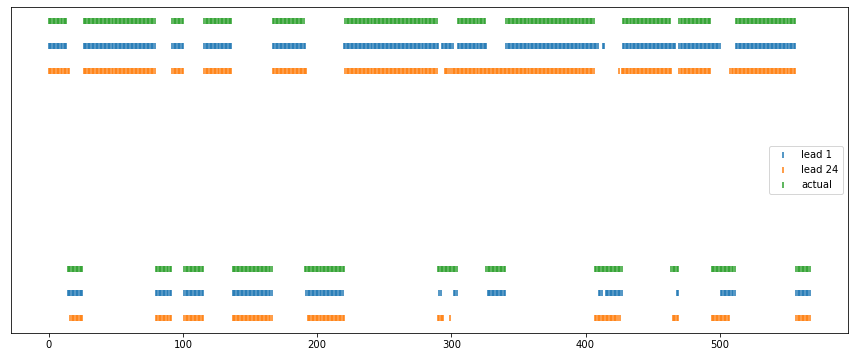

In [21]:
plt.figure(figsize=(15, 6))

plt.scatter(list(range(len(y_p[23]))), y_p[0][23:]-0.1, label='lead 1', marker='|')
plt.scatter(list(range(len(y_p[23]))),y_p[23]-0.2, label='lead 24', marker='|')
plt.scatter(list(range(len(y_p[23]))),y_t[23], label='actual', marker='|')
plt.yticks([])
plt.legend()

In [29]:
confusion_matrix(y_p[0], y_t[0])

array([[152,   0],
       [ 33, 406]], dtype=int64)

In [30]:
confusion_matrix(y_p[23], y_t[23])

array([[145,   0],
       [ 40, 383]], dtype=int64)